## EDA for Home Credit Default Risk
---

* Follow this [notebook](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction#Data) and understand this task


### Data
---

In [1]:
import sys, os, warnings, re

sys.path.insert(1, "../..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings("ignore")

In [8]:
data_dir = Path("../../data/home-credit-default-risk/")
list(data_dir.glob("*.parquet"))

[PosixPath('../../data/home-credit-default-risk/processed_data.parquet')]

In [12]:
path = list(data_dir.glob("*.parquet"))[0]
df = pd.read_parquet(path)
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
display(df.shape)
display(df.head())

(356251, 798)

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
train_df = df[~df.TARGET.isna()]
test_df = df[df.TARGET.isna()]

In [14]:
train_df.shape, test_df.shape

((307507, 798), (48744, 798))

In [15]:
train_df.to_parquet("../../data/home-credit-default-risk/train_df.parquet")
test_df.to_parquet("../../data/home-credit-default-risk/test_df.parquet")

### Run a simple LGBM to get feature importance
---

We will use the top list of features for debugging purposes.

Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
[LightGBM] [Warning] num_threads is set with nthread=4, will be overridden by n_jobs=-1. Current value: num_threads=-1
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.799298	training's binary_logloss: 0.234569	valid_1's auc: 0.769271	valid_1's binary_logloss: 0.24354
[400]	training's auc: 0.823056	training's binary_logloss: 0.224476	valid_1's auc: 0.7796	valid_1's binary_logloss: 0.23959
[600]	training's auc: 0.838731	training's binary_logloss: 0.218034	valid_1's auc: 0.783216	valid_1's binary_logloss: 0.238382
[800]	training's auc: 0.851733	training's binary_logloss: 0.212639	valid_1's auc: 0.784888	valid_1's binary_logloss: 0.237854
[1000]	training's auc: 0.863292	training's binary_logloss: 0.207755	valid_1's auc: 0.785627	valid_1's binary_logloss: 0.237583
[1200]	training's auc: 0.873142	training's binary_logloss: 0.203325	valid_1's auc: 0.785764	valid_1's binary_logloss: 0.

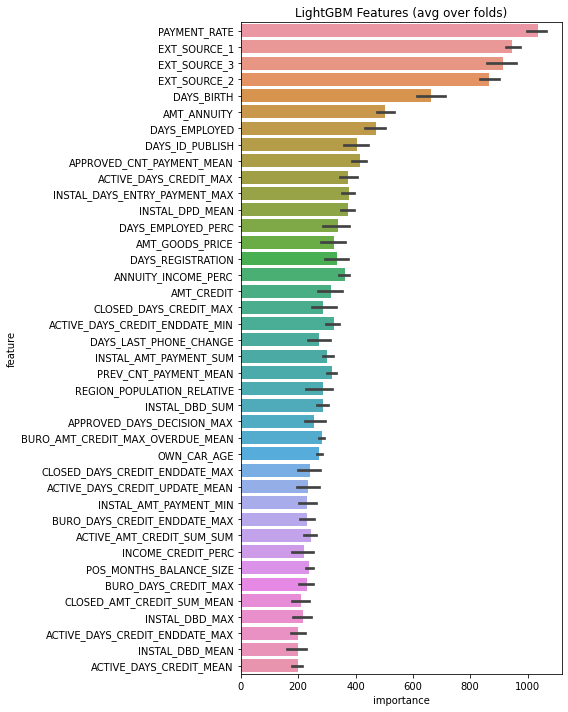

In [7]:
from src.load_data import kfold_lightgbm

%time fimp = kfold_lightgbm(df, 5, stratified=True, debug=False)

In [8]:
fimp

,feature,importance,fold
0,CODE_GENDER,161,1
1,FLAG_OWN_CAR,5,1
2,FLAG_OWN_REALTY,16,1
3,CNT_CHILDREN,6,1
4,AMT_INCOME_TOTAL,73,1
...,...,...,...
790,CC_NAME_CONTRACT_STATUS_nan_MAX,0,5
791,CC_NAME_CONTRACT_STATUS_nan_MEAN,0,5
792,CC_NAME_CONTRACT_STATUS_nan_SUM,0,5
793,CC_NAME_CONTRACT_STATUS_nan_VAR,0,5


In [9]:
fimp.to_csv("./simple-feature-importance.csv")